In [164]:
from sklearn.datasets import load_diabetes
import pickle
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import os


from synthcity.metrics.eval_performance import (
    PerformanceEvaluatorMLP,
    PerformanceEvaluatorXGB,
)
from synthcity.utils import reproducibility
from synthcity.plugins import Plugins
import synthcity.logger as log
from synthcity.plugins.core.dataloader import GenericDataLoader

Plugins(categories=["generic"]).list()

['adsgan',
 'dpgan',
 'sdv_tvae',
 'privbayes',
 'nflow',
 'copulagan',
 'tvae',
 'gaussian_copula',
 'pategan',
 'bayesian_network',
 'sdv_ctgan',
 'rtvae',
 'ctgan']

In [165]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_diabetes
from sklearn.datasets import load_boston
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_wine
from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

dataset = 'moons'
p_train = 0.5

if dataset=='diabetes':
    X, y = load_diabetes(return_X_y=True, as_frame=True)
elif dataset=='iris':
    X, y = load_iris(return_X_y=True, as_frame=True)
elif dataset=='boston':
    X, y = load_boston(return_X_y=True, as_frame=True)
elif dataset=='breast_cancer':
    X, y = load_breast_cancer(return_X_y=True, as_frame=True)
elif dataset=='wine':
    X, y = load_wine(return_X_y=True, as_frame=True)
elif dataset=='digits':
    X, y = load_digits(return_X_y=True, as_frame=True)
elif dataset=='moons':
    X, y = make_moons(n_samples=2000, noise=0.2, random_state=0)
    X = pd.DataFrame(X)
    p_train = 0.1
elif dataset in ['8gaussians', '25gaussians', '50spirals', 'swissroll', 'chessboard']:
    X = pd.read_csv(f'./data/{dataset}.csv')
    y = pd.read_csv(f'./data/{dataset}_labels.csv')
else:
    raise ValueError('Unknown dataset')

X["target"] = y
X_gt = GenericDataLoader(X, target_column="target", train_size=p_train)
if len(np.unique(y))<=10:
    X_gt.targettype = 'classification'
else:
    X_gt.targettype = 'regression'

X_train, X_test = X_gt.train(), X_gt.test()

nsyn = len(X_test)
results_folder = "uncertainty_results/"+dataset
n_models = 10


In [166]:
print(X_train.shape, X_test.shape)

(200, 3) (1800, 3)


In [167]:
load = True

for i in range(n_models):
    os.makedirs(results_folder, exist_ok=True)
    filename = f"{results_folder}/X_syn_{i}.pkl"
    if os.path.exists(filename) and load:
        continue
    print(f"Training model {i+1}/{n_models}")

    syn_model = Plugins().get('tvae')
    reproducibility.enable_reproducible_results(seed=i)
    syn_model.fit(X_train)
    X_syn = syn_model.generate(count = nsyn)
    # save X_syn to disk as pickle
    pickle.dump(X_syn, open(filename, "wb"))





In [168]:
X_syns = []
for i in range(n_models):
    # load X_syn from disk as pickle
    X_syn = pickle.load(open(f"{results_folder}/X_syn_{i}.pkl", "rb"))
    X_syns.append(X_syn)

In [169]:
def prediction_task(X_gt, X_syn, model=None):
    if type(model)==str or model is None:
        if model=='mlp' or model is None:
            if X_gt.targettype == 'classification':
                model = sklearn.neural_network.MLPClassifier()
            else:
                model = sklearn.neural_network.MLPRegressor()
        elif model=='rf':
            if X_gt.targettype == 'classification':
                model = sklearn.ensemble.RandomForestClassifier()
            else:
                model = sklearn.ensemble.RandomForestRegressor()
        X, y = X_syn.unpack(as_numpy=True)
        model.fit(X, y.reshape(-1,1))
    pred = model.predict(X_gt.unpack(as_numpy=True)[0])
    return pred, model

#task = lambda X_gt, X_syn: PerformanceEvaluatorMLP(X_gt = X_gt, X_syn=GenericDataLoader(X_syn, target_column='target'))

def meanstd(A):
    return np.mean(A, axis=0), np.std(A, axis=0)

def aggregate(X_gt, X_syns, task, models=None):
    results = []
    trained_models = []
    for i in range(len(X_syns)):
        if models is None:
            model = None
        else:
            model = models[i]
        res, model = task(X_gt, X_syns[i], model)
        results.append(res)
        trained_models.append(model)
    return *meanstd(results), trained_models


In [170]:
X_test = X_gt.test()
X_test.targettype = X_gt.targettype
y_pred_mean, y_pred_std, models = aggregate(X_test, X_syns, prediction_task, models=['mlp']*len(X_syns))


def tsne(X):
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=0)
    X_2d = tsne.fit_transform(X)
    return X_2d


X, y = X_gt.test().unpack(as_numpy=True)
if X.shape[1]>2:
    Xplot = tsne(X)
else:
    Xplot = X
for y in [y_pred_mean, y_pred_std]:
    plt.scatter(Xplot[:,0], Xplot[:,1], c=y, cmap='viridis')
    plt.colorbar()
    plt.show()


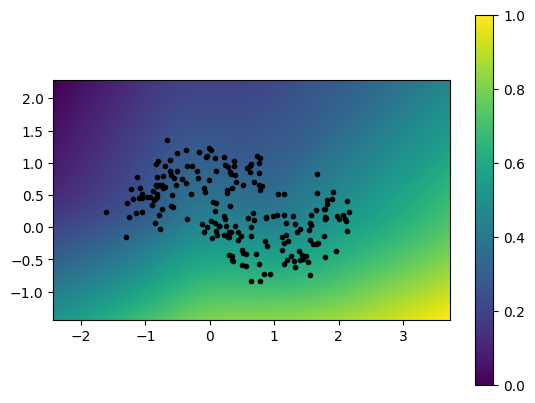

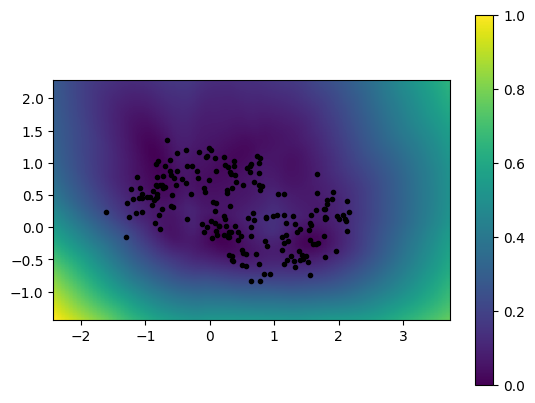

In [ ]:
def aggregate_imshow(X_gt, X_syns, task, models=None):
    xmin, ymin = np.min(X_gt.unpack(as_numpy=True)[0], axis=0)*1.5
    xmax, ymax = np.max(X_gt.unpack(as_numpy=True)[0], axis=0)*1.5
    
    X_grid = np.linspace(xmin, xmax, 100)
    Y_grid = np.linspace(ymin, ymax, 100)

    X_grid, Y_grid = np.meshgrid(X_grid, Y_grid)
    X_grid = pd.DataFrame(np.c_[X_grid.ravel(), Y_grid.ravel()])
    X_grid['target'] = 0
    X_grid = GenericDataLoader(X_grid, target_column="target", train_size=0.01)

    y_pred_mean, y_pred_std, models = aggregate(X_grid, X_syns, task, models)

    for y in (y_pred_mean, y_pred_std):
        plt.imshow(y.reshape(100,100)[::-1], cmap='viridis', extent=[xmin, xmax, ymin, ymax])
        X_train, y_train = X_gt.train().unpack(as_numpy=True)
        if len(np.unique(y_train))==2:
            y_train = y_train.astype(bool)        
            plt.scatter(X_train[y_train,0], X_train[y_train,1], c='k', marker='.')
            plt.scatter(X_train[~y_train,0], X_train[~y_train,1], c='k', marker='.')
        plt.colorbar()
        plt.show()

aggregate_imshow(X_gt, X_syns, prediction_task, models)



TypeError: 'AxesSubplot' object is not subscriptable

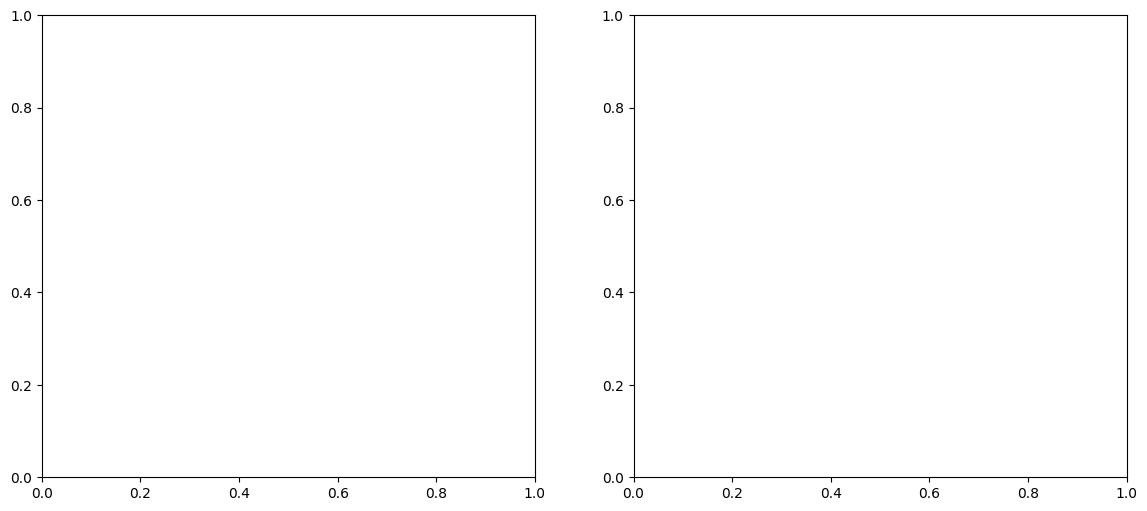

In [ ]:
loader = GenericDataLoader(X, target_column="target")
syn_model.plot(plt, loader)

plt.show()